## 2.1 Data upload

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re

from collections import Counter
from collections import defaultdict

In [2]:
df = pd.read_csv('https://github.com/hemanth-07-11/Health-Survelliance-using-twitter-data/blob/main/Mental%20Health%20Analysis/mental_health_data.csv?raw=true').iloc[:,1:]
df.head()

,title,body,author,url,score,upvote_ratio,subreddit
0,Craving closeness,"About a year ago, I got into a relationship th...",Nash4N00b,https://www.reddit.com/r/mentalhealth/comments...,2,1.00,mentalhealth
1,Mental health class,I think schools should have a mandatory mental...,ConnecticutJohn,https://www.reddit.com/r/mentalhealth/comments...,112,0.97,mentalhealth
2,My 7yo son accidentally fell on our pet bird a...,It was TRULY a freak accident and not expected...,AnonymousCounselor52,https://www.reddit.com/r/mentalhealth/comments...,387,0.97,mentalhealth
3,Who else doesn’t want covid world to leave,My mental health has been so bad and I’ve been...,jjdabest8820,https://www.reddit.com/r/mentalhealth/comments...,15,0.94,mentalhealth
4,my mental health is suffering due to my contro...,note: please read my previous posts for contex...,Wooden_View_7120,https://www.reddit.com/r/mentalhealth/comments...,7,0.83,mentalhealth


In [3]:
df.shape

(6239, 7)

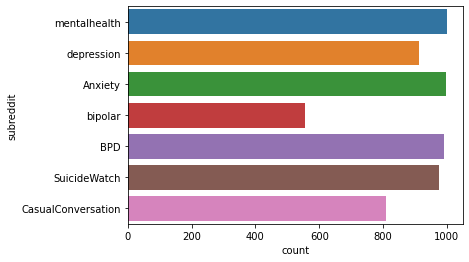

In [4]:
sns.countplot(y="subreddit", data=df)

## 2.2 Missing values

In [5]:
df.isna().sum()

title             0
body            316
author           26
url               0
score             0
upvote_ratio      0
subreddit         0
dtype: int64

In [6]:
df[df['author'].isna()].reset_index()['url'][:5]

0    https://www.reddit.com/r/mentalhealth/comments...
1    https://www.reddit.com/r/mentalhealth/comments...
2    https://www.reddit.com/r/mentalhealth/comments...
3    https://www.reddit.com/r/depression/comments/n...
4    https://www.reddit.com/r/depression/comments/n...
Name: url, dtype: object

In [7]:
df[df['body'].isna()].groupby('subreddit').count()['title']

subreddit
Anxiety          20
SuicideWatch     45
bipolar         232
depression        7
mentalhealth     12
Name: title, dtype: int64

In [8]:
df[(df['body'].isna()) & (df['subreddit']=='bipolar')].reset_index()['url'][:5]

0      https://i.redd.it/inr6td85lrw61.jpg
1      https://i.redd.it/6hgatwtv0rw61.jpg
2    https://www.reddit.com/gallery/n3p1t5
3      https://i.redd.it/35rj80rxtqw61.jpg
4      https://i.redd.it/2mirmpc2duw61.jpg
Name: url, dtype: object

In [9]:
df = df[~((df['body'].isna()) & (df['subreddit'].isin(['bipolar', 'mentalhealth'])))].reset_index().drop('index', axis=1)

In [10]:
df[(df['body'].isna()) & (df['subreddit']=='SuicideWatch')].reset_index()['url'][:5]

0    https://www.reddit.com/r/SuicideWatch/comments...
1    https://www.reddit.com/r/SuicideWatch/comments...
2    https://www.reddit.com/r/SuicideWatch/comments...
3    https://www.reddit.com/r/SuicideWatch/comments...
4    https://www.reddit.com/r/SuicideWatch/comments...
Name: url, dtype: object

In [11]:
df.fillna('', inplace=True)

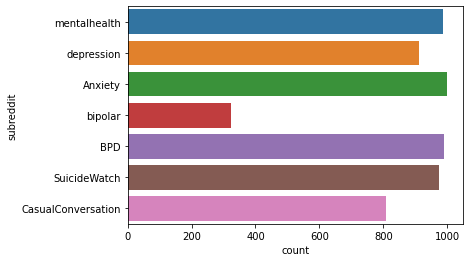

In [12]:
sns.countplot(y="subreddit", data=df)

In [13]:
df.shape

(5995, 7)

## 2.3 Preprocessing

In [14]:
df['full_text'] = df['title'] + " " + df['body']

In [15]:
def reddit_specific_preprocessing(text):
    
    text = re.sub(r'\n+', ' ', text)

    text = re.sub(r'\"?\\?&?gt;?', '', text)

    text = re.sub(r'\*', '', text)

    text = re.sub('&amp;#x200B;', '', text)

    text = re.sub(r'\[.*?\]\(.*?\)', '', text)

    text = re.sub('~', '', text)

    text = re.sub('&lt;', '', text)
    text = re.sub(r'!(.*?)!', r'\1', text)
    text = re.sub('`', '', text)

    text = re.sub(r'\^\((.*?)\)', r'\1', text)

    text = re.sub(r'\|', ' ', text)
    text = re.sub(':-', '', text)

    text = re.sub('#', '', text)

    text = text.strip()
    text = re.sub(r'\s\s+', ' ', text)

    return text

In [16]:
df_preprocessing = df[['url', 'full_text']].copy()

In [17]:
df_preprocessing.head()

,url,full_text
0,https://www.reddit.com/r/mentalhealth/comments...,"Craving closeness About a year ago, I got into..."
1,https://www.reddit.com/r/mentalhealth/comments...,Mental health class I think schools should hav...
2,https://www.reddit.com/r/mentalhealth/comments...,My 7yo son accidentally fell on our pet bird a...
3,https://www.reddit.com/r/mentalhealth/comments...,Who else doesn’t want covid world to leave My ...
4,https://www.reddit.com/r/mentalhealth/comments...,my mental health is suffering due to my contro...


In [18]:
df_preprocessing['01_reddit_specific'] = df_preprocessing['full_text'].apply(lambda text: reddit_specific_preprocessing(text))

In [19]:
df_preprocessing['01_reddit_specific'][0]

'Craving closeness About a year ago, I got into a relationship that lasted until December 2020. I was the one that broke up. I loved her, but I didn’t see a satisfying future for me, so it was a tough decision to make. The problem is that I now really crave the closeness I had with her, cause I don’t really get that with anyone else. I want the love we had for each other with someone else, and it’s really annoying. I want the spooning, the sex, everything. I’m only 18, so it’s probably not something I should be thinking about, but I do. Is this normal, or should I seek help?'

### 2.3.2 General purpose preprocessing

#### Remove stopwords

In [20]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

STOPWORDS = set(stopwords.words('english'))

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df_preprocessing['02_remove_stopwords'] = df_preprocessing['01_reddit_specific'].apply(lambda text: remove_stopwords(text))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [21]:
df_preprocessing['02_remove_stopwords'][0]

'Craving closeness About year ago, I got relationship lasted December 2020. I one broke up. I loved her, I didn’t see satisfying future me, tough decision make. The problem I really crave closeness I her, cause I don’t really get anyone else. I want love someone else, it’s really annoying. I want spooning, sex, everything. I’m 18, it’s probably something I thinking about, I do. Is normal, I seek help?'

#### Remove punctuation

In [22]:
import string

PUNCTUATION = string.punctuation

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCTUATION))

df_preprocessing['03_remove_punctuation'] = df_preprocessing['02_remove_stopwords'].apply(lambda text: remove_punctuation(text))

In [23]:
df_preprocessing['03_remove_punctuation'][0]

'Craving closeness About year ago I got relationship lasted December 2020 I one broke up I loved her I didn’t see satisfying future me tough decision make The problem I really crave closeness I her cause I don’t really get anyone else I want love someone else it’s really annoying I want spooning sex everything I’m 18 it’s probably something I thinking about I do Is normal I seek help'

#### Lemmatization

In [24]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [25]:
def lemmatize(text, pos_list=None):
    
    if pos_list is None:
        return [token.lemma_ for token in nlp(text)]
    
    else:
        return [token.lemma_ for token in nlp(text) if token.pos_ in pos_list]

In [26]:
df_preprocessing['lemmatization_standard'] = df_preprocessing['03_remove_punctuation'].apply(lambda text: lemmatize(text))
df_preprocessing['lemmatization_standard'] = df_preprocessing['lemmatization_standard'].apply(lambda tokens: ' '.join(tokens))

In [27]:
df_preprocessing['lemmatization_standard'][0]

'crave closeness about year ago -PRON- get relationship last December 2020 -PRON- one break up -PRON- love -PRON- -PRON- do not see satisfy future -PRON- tough decision make the problem -PRON- really crave closeness -PRON- -PRON- cause -PRON- do not really get anyone else -PRON- want love someone else -PRON- ’ really annoying -PRON- want spoon sex everything -PRON- be 18 -PRON- ’ probably something -PRON- think about -PRON- do be normal -PRON- seek help'

In [28]:
pos_list = ['NOUN', 'ADJ']
df_preprocessing['lemmatization_nuon_adj'] = df_preprocessing['03_remove_punctuation'].apply(lambda text: lemmatize(text, pos_list=pos_list))
df_preprocessing['lemmatization_nuon_adj'] = df_preprocessing['lemmatization_nuon_adj'].apply(lambda tokens: ' '.join(tokens))

In [29]:
df_preprocessing['lemmatization_nuon_adj'][0]

'closeness year relationship future tough decision problem closeness love annoying sex normal help'

## 2.4 Pre-Post processing analysis

In [30]:
df_preprocessing = df_preprocessing.merge(df[['url', 'subreddit']], on='url')

In [31]:
subreddits = list(set(df['subreddit']))
subreddits

['CasualConversation',
 'depression',
 'mentalhealth',
 'SuicideWatch',
 'Anxiety',
 'bipolar',
 'BPD']

### Number chars

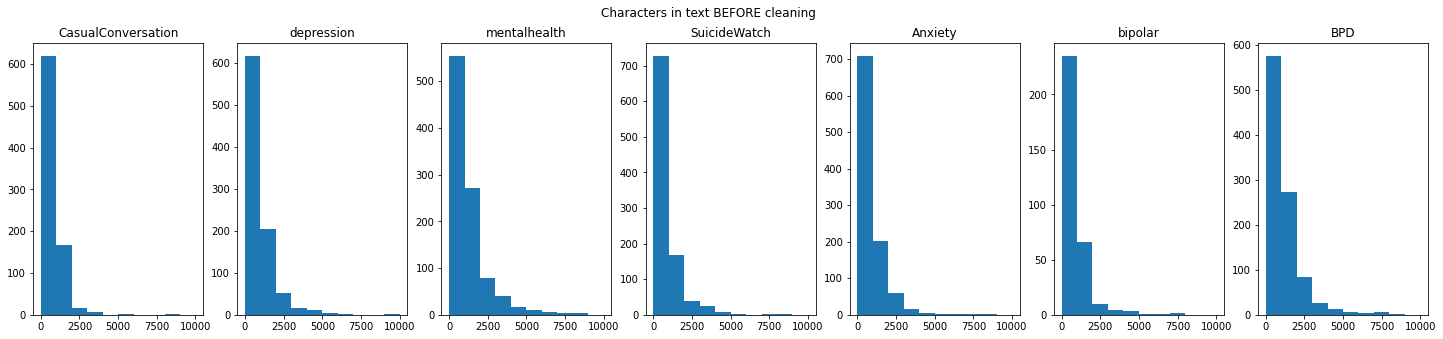

In [32]:
fig, ax= plt.subplots(1, len(subreddits) ,figsize=(25,5))

for i, sub in enumerate(subreddits):
    
    text_len = df_preprocessing[df_preprocessing['subreddit']==sub]['full_text'].str.len()
    ax[i].hist(text_len, range=(0, 10000))
    ax[i].set_title(sub)
    
fig.suptitle('Characters in text BEFORE cleaning')
plt.show()

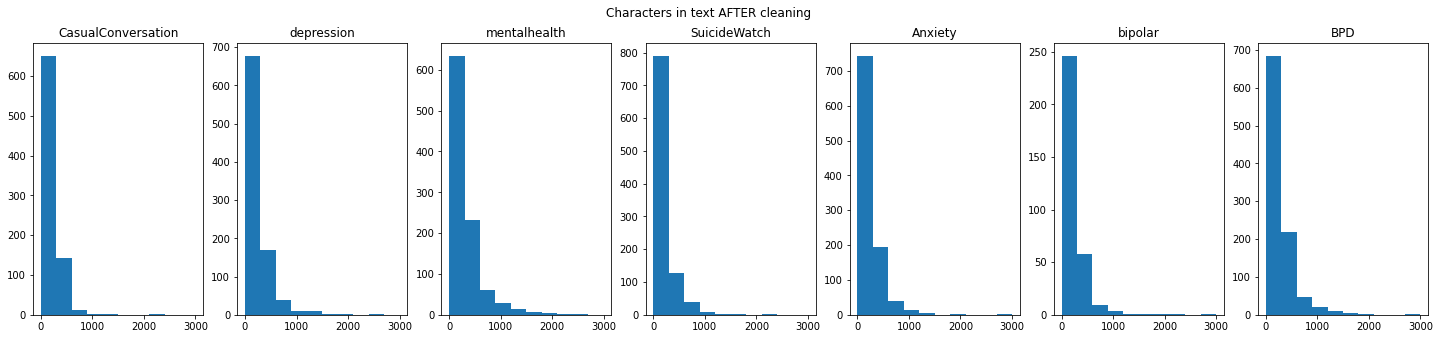

In [33]:
fig, ax= plt.subplots(1, len(subreddits) ,figsize=(25,5))

for i, sub in enumerate(subreddits):
    
    text_len = df_preprocessing[df_preprocessing['subreddit']==sub]['lemmatization_nuon_adj'].str.len()
    ax[i].hist(text_len, range=(0, 3000))
    ax[i].set_title(sub)
    
fig.suptitle('Characters in text AFTER cleaning')
plt.show()

### Number words

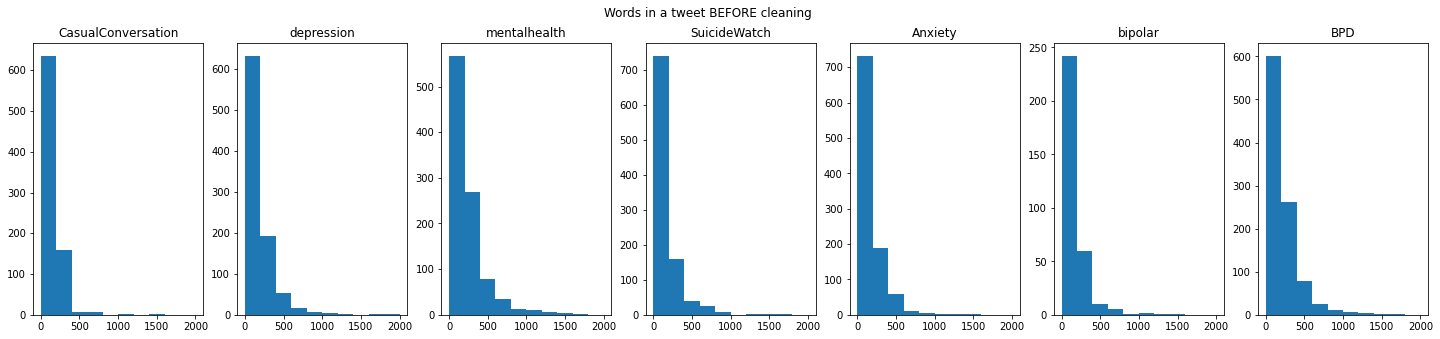

In [34]:
fig, ax= plt.subplots(1, len(subreddits) ,figsize=(25,5))

for i, sub in enumerate(subreddits):
    
    text_len = df_preprocessing[df_preprocessing['subreddit']==sub]['full_text'].str.split().map(lambda x: len(x))
    ax[i].hist(text_len, range=(0, 2000))
    ax[i].set_title(sub)
    
fig.suptitle('Words in a tweet BEFORE cleaning')
plt.show()

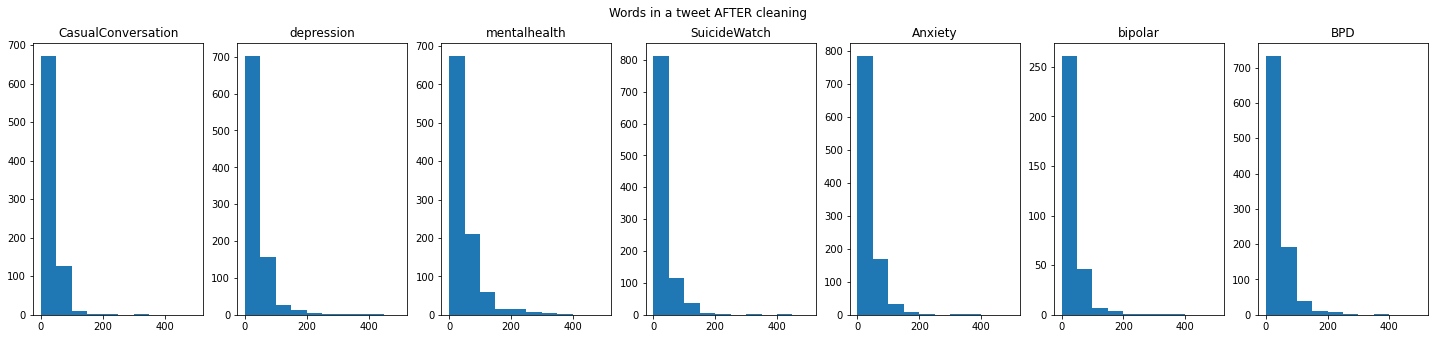

In [35]:
fig, ax= plt.subplots(1, len(subreddits) ,figsize=(25,5))

for i, sub in enumerate(subreddits):
    
    text_len = df_preprocessing[df_preprocessing['subreddit']==sub]['lemmatization_nuon_adj'].str.split().map(lambda x: len(x))
    ax[i].hist(text_len, range=(0, 500))
    ax[i].set_title(sub)
    
fig.suptitle('Words in a tweet AFTER cleaning')
plt.show()

# 3. Analysis 

## 3.1 Language models

### BOW 

In [36]:
from sklearn.feature_extraction.text import CountVectorizer

In [37]:
def bow_most_common(data, ngram):
    
    bow = CountVectorizer(analyzer='word', 
                      ngram_range=(ngram, ngram), 
                      min_df=0.001, 
                      max_df=0.75, 
                      stop_words='english') 
    
    X = bow.fit_transform(data)
    return Counter(dict(zip(bow.get_feature_names(), X.sum(axis=0).A1))).most_common(10)

#### Original text

In [38]:
bow_most_common(data=df_preprocessing['full_text'], ngram=1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[('just', 9132),
 ('like', 7843),
 ('feel', 6154),
 ('don', 6023),
 ('know', 4719),
 ('ve', 4407),
 ('want', 4089),
 ('time', 3549),
 ('really', 3491),
 ('life', 3410)]

In [39]:
bow_most_common(data=df_preprocessing['full_text'], ngram=2)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[('feel like', 2246),
 ('don know', 1643),
 ('don want', 944),
 ('just want', 622),
 ('mental health', 546),
 ('feels like', 425),
 ('just don', 333),
 ('don think', 324),
 ('just feel', 304),
 ('felt like', 295)]

In [40]:
bow_most_common(data=df_preprocessing['full_text'], ngram=3)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[('just feel like', 116),
 ('just don know', 105),
 ('don feel like', 91),
 ('don know anymore', 66),
 ('mental health issues', 66),
 ('feel like ve', 65),
 ('feel like just', 59),
 ('just don want', 53),
 ('don know just', 52),
 ('makes feel like', 52)]

#### Preprocessed text

In [41]:
bow_most_common(data=df_preprocessing['lemmatization_nuon_adj'], ngram=1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[('time', 4231),
 ('thing', 3450),
 ('life', 3343),
 ('people', 3317),
 ('day', 2973),
 ('year', 2750),
 ('friend', 2588),
 ('bad', 2334),
 ('good', 2101),
 ('anxiety', 2010)]

In [42]:
bow_most_common(data=df_preprocessing['lemmatization_nuon_adj'], ngram=2)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[('mental health', 499),
 ('year old', 311),
 ('panic attack', 300),
 ('good friend', 275),
 ('long time', 207),
 ('high school', 160),
 ('time time', 125),
 ('day day', 124),
 ('suicidal thought', 120),
 ('hard time', 119)]

In [43]:
bow_most_common(data=df_preprocessing['lemmatization_nuon_adj'], ngram=3)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[('mental health issue', 66),
 ('long story short', 33),
 ('anxiety panic attack', 20),
 ('mental health problem', 19),
 ('life year old', 16),
 ('bad mental health', 13),
 ('bad panic attack', 13),
 ('good friend year', 13),
 ('year old life', 13),
 ('year old male', 13)]

#### Specific subreddit: SuicideWatch

In [44]:
data_suicide_watch = df_preprocessing[df_preprocessing['subreddit']=='SuicideWatch']['full_text']

In [45]:
bow_most_common(data=data_suicide_watch, ngram=1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[('just', 1442),
 ('don', 1087),
 ('like', 965),
 ('want', 919),
 ('life', 820),
 ('feel', 767),
 ('know', 641),
 ('ve', 605),
 ('people', 546),
 ('think', 425)]

In [46]:
bow_most_common(data=data_suicide_watch, ngram=2)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[('feel like', 291),
 ('don want', 243),
 ('don know', 240),
 ('just want', 151),
 ('want die', 104),
 ('don think', 83),
 ('just don', 74),
 ('feels like', 61),
 ('suicidal thoughts', 55),
 ('ve tried', 41)]

In [47]:
bow_most_common(data=data_suicide_watch, ngram=3)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[('just don want', 20),
 ('just want die', 20),
 ('don want live', 19),
 ('just feel like', 16),
 ('don want die', 15),
 ('just don know', 15),
 ('feel like ve', 12),
 ('want die don', 12),
 ('makes feel like', 11),
 ('don feel like', 10)]

In [48]:
data_suicide_watch = df_preprocessing[df_preprocessing['subreddit']=='SuicideWatch']['lemmatization_nuon_adj']

In [49]:
bow_most_common(data=data_suicide_watch, ngram=1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[('life', 799),
 ('people', 544),
 ('time', 491),
 ('thing', 434),
 ('year', 434),
 ('friend', 377),
 ('day', 369),
 ('bad', 322),
 ('good', 288),
 ('suicide', 249)]

In [50]:
bow_most_common(data=data_suicide_watch, ngram=2)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[('year old', 50),
 ('suicidal thought', 47),
 ('friend family', 34),
 ('mental health', 33),
 ('good friend', 32),
 ('long time', 26),
 ('high school', 24),
 ('life bad', 22),
 ('end life', 21),
 ('people life', 21)]

In [51]:
bow_most_common(data=data_suicide_watch, ngram=3)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[('fuck fuck fuck', 5),
 ('long story short', 5),
 ('good friend year', 4),
 ('mental health issue', 4),
 ('year good friend', 4),
 ('18th birthday dad', 3),
 ('able ejaculate piece', 3),
 ('age able ejaculate', 3),
 ('apartment apartment good', 3),
 ('apartment good good', 3)]

### TF-IDF

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [53]:
def tfidf_score(data, result=False):
    tfidf = TfidfVectorizer(analyzer='word', 
                            min_df=0.001, 
                            max_df=0.75, 
                            stop_words='english', 
                            sublinear_tf=True)

    X_tfidf = tfidf.fit_transform(data)

    bow = CountVectorizer(analyzer='word', 
                          min_df=0.001, 
                          max_df=0.75, 
                          stop_words='english')

    X_bow = bow.fit_transform(data)

    words = pd.DataFrame(data={'word': bow.get_feature_names(), 
                               'tf': X_bow.sum(axis=0).A1, 
                               'idf': tfidf.idf_,
                               'tfidf': X_tfidf.sum(axis=0).A1}).sort_values(['tfidf', 'tf', 'idf'], ascending=False).reset_index().drop('index', axis=1)

    
    if result:
        return words
    
    print('Words with highest TF-IDF score')
    print()
    print(words.head(10))
    print()
    print('Words with lowest TF-IDF score')
    print()
    print(words.tail(10))

In [54]:
tfidf_score(data=df_preprocessing['full_text'])

Words with highest TF-IDF score

     word    tf       idf       tfidf
0    just  9132  1.496365  248.309559
1    like  7843  1.589322  225.186726
2    feel  6154  1.765409  210.771047
3     don  6023  1.784961  202.747297
4    want  4089  2.011309  175.408830
5    know  4719  1.872405  172.972850
6      ve  4407  1.995389  165.345236
7    life  3410  2.180241  150.583065
8  really  3491  2.144513  145.266222
9  people  3316  2.227485  141.590639

Words with lowest TF-IDF score

               word  tf       idf     tfidf
5609      summarize   6  7.752938  0.621865
5610       gorgeous   6  7.752938  0.616453
5611  consideration   6  7.752938  0.609517
5612    unknowingly   6  7.752938  0.607130
5613    transparent   6  7.752938  0.575454
5614     pedophilia   6  7.752938  0.554672
5615        remarks   6  7.752938  0.541486
5616    socialising   6  7.752938  0.534423
5617        disdain   6  7.752938  0.521466
5618         tables   6  7.752938  0.520355


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [55]:
tfidf_score(data=df_preprocessing['lemmatization_nuon_adj'])

Words with highest TF-IDF score

      word    tf       idf       tfidf
0     time  4231  1.952547  226.750941
1     life  3343  2.187870  216.069013
2   people  3317  2.225211  208.758595
3    thing  3450  2.151874  199.512169
4      day  2973  2.241239  190.585880
5   friend  2588  2.468285  177.919087
6      bad  2334  2.398375  174.151564
7     year  2750  2.291530  172.728274
8  anxiety  2010  2.696692  167.663904
9     good  2101  2.455335  157.158225

Words with lowest TF-IDF score

               word  tf       idf     tfidf
2880           oral   8  7.752938  0.963848
2881         vacuum   6  7.752938  0.962565
2882            dot   6  7.752938  0.960488
2883       profound   7  7.752938  0.949055
2884       gorgeous   6  7.752938  0.927500
2885        measure   6  7.752938  0.926234
2886  consideration   6  7.752938  0.920524
2887       contrary   6  7.752938  0.889470
2888    transparent   6  7.752938  0.835041
2889         remark   7  7.752938  0.756246


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [56]:
for subreddit in list(set(df_preprocessing['subreddit'])):
    print('*** ', subreddit, ' ***')
    print()
    tfidf_score(data=df_preprocessing[df_preprocessing['subreddit']==subreddit]['lemmatization_nuon_adj'])
    print()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


***  CasualConversation  ***

Words with highest TF-IDF score

     word   tf       idf      tfidf
0    time  444  2.035308  27.258710
1  people  403  2.234436  25.693557
2    good  310  2.346410  23.222915
3  friend  313  2.604518  22.645860
4    year  332  2.295591  22.443357
5     day  317  2.341682  21.971088
6   thing  288  2.467159  20.546147
7    life  240  2.629364  20.058654
8   today  151  2.997788  13.979107
9     new  133  3.034829  13.256468

Words with lowest TF-IDF score

            word  tf       idf     tfidf
4432    takeaway   1  7.005121  0.065258
4433     tension   1  7.005121  0.065258
4434      tragic   1  7.005121  0.065258
4435      tricky   1  7.005121  0.065258
4436    unending   1  7.005121  0.065258
4437     unkempt   1  7.005121  0.065258
4438    upstairs   1  7.005121  0.065258
4439       venue   1  7.005121  0.065258
4440  whitestone   1  7.005121  0.065258
4441      wiring   1  7.005121  0.065258

***  depression  ***

Words with highest TF-IDF score

 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Words with highest TF-IDF score

     word   tf       idf      tfidf
0    time  960  1.764456  38.150944
1   thing  805  1.942439  34.279183
2  people  656  2.111858  33.324555
3     bad  553  2.111858  32.253472
4    life  587  2.143110  32.104429
5     day  649  2.090548  31.356738
6  friend  595  2.253776  29.552506
7    year  594  2.099625  29.367486
8  mental  410  2.327338  28.274732
9    good  410  2.350505  24.781521

Words with lowest TF-IDF score

              word  tf       idf     tfidf
5379          teeh   1  7.202536  0.052488
5380   temperature   1  7.202536  0.052488
5381  thunderstorm   1  7.202536  0.052488
5382          ting   1  7.202536  0.052488
5383        toearn   1  7.202536  0.052488
5384         tonbe   1  7.202536  0.052488
5385           tor   1  7.202536  0.052488
5386     vegetabel   1  7.202536  0.052488
5387           wit   1  7.202536  0.052488
5388           wnd   1  7.202536  0.052488

***  SuicideWatch  ***



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Words with highest TF-IDF score

      word   tf       idf      tfidf
0     life  799  1.864869  46.801587
1   people  544  2.263062  36.076853
2     time  491  2.234488  32.694601
3   friend  377  2.374074  31.170347
4    thing  434  2.362002  30.148762
5      day  369  2.432424  29.261930
6      bad  322  2.541128  28.279048
7     year  434  2.338285  27.521616
8  suicide  249  2.741799  23.756000
9      way  234  2.701679  22.379965

Words with lowest TF-IDF score

              word  tf       idf    tfidf
4146      stagnant   1  7.190315  0.05856
4147       stillim   1  7.190315  0.05856
4148  stresstrauma   1  7.190315  0.05856
4149         trade   1  7.190315  0.05856
4150       trivial   1  7.190315  0.05856
4151    ungrateful   1  7.190315  0.05856
4152  unreasonable   1  7.190315  0.05856
4153          wand   1  7.190315  0.05856
4154     warranted   1  7.190315  0.05856
4155     withstand   1  7.190315  0.05856

***  Anxiety  ***



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Words with highest TF-IDF score

      word    tf       idf      tfidf
0  anxiety  1370  1.469003  63.302036
1     time   612  2.017877  34.260442
2      bad   477  2.173414  32.439239
3      day   485  2.186443  31.823354
4   attack   359  2.508592  30.399652
5  anxious   326  2.421958  29.443654
6    thing   451  2.254266  28.114413
7   people   340  2.554897  25.222884
8    panic   278  2.724971  24.726608
9     year   366  2.460017  24.308887

Words with lowest TF-IDF score

             word  tf       idf    tfidf
4436      refrain   1  7.213608  0.06547
4437     rhetoric   1  7.213608  0.06547
4438         slab   1  7.213608  0.06547
4439    spotlight   1  7.213608  0.06547
4440         tank   1  7.213608  0.06547
4441   ubiquitous   1  7.213608  0.06547
4442  unrelenting   1  7.213608  0.06547
4443       vacuum   1  7.213608  0.06547
4444      wakeful   1  7.213608  0.06547
4445  wakefulness   1  7.213608  0.06547

***  bipolar  ***

Words with highest TF-IDF score

      word  

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Words with highest TF-IDF score

           word   tf       idf      tfidf
0          time  864  1.775040  39.483285
1        people  721  1.988926  38.064972
2         thing  782  1.883566  36.759716
3        friend  492  2.386294  30.549789
4          life  497  2.226400  30.374422
5  relationship  470  2.419084  28.946461
6           day  493  2.216143  28.176336
7           bad  414  2.327569  27.630922
8          year  434  2.305012  26.560298
9          good  392  2.286595  26.315855

Words with lowest TF-IDF score

              word  tf       idf     tfidf
4859        reader   1  7.206576  0.055536
4860  reevaluation   1  7.206576  0.055536
4861   retaliation   1  7.206576  0.055536
4862        screed   1  7.206576  0.055536
4863        specie   1  7.206576  0.055536
4864       ugliest   1  7.206576  0.055536
4865       unequal   1  7.206576  0.055536
4866    unwavering   1  7.206576  0.055536
4867         whine   1  7.206576  0.055536
4868         wound   1  7.206576  0.055536

Aggregate all the documents belonging to the same subreddit in one single document and repeat the procedure above. In this way, the TF-IDF will give a bigger weight to common words within a subreddit which are uncommon in other subreddits.

In [57]:
document_list = []

for subreddit in list(set(df_preprocessing['subreddit'])):
    document_list.append(' '.join(df_preprocessing[df_preprocessing['subreddit']==subreddit]['lemmatization_nuon_adj']))
    
tfidf_score(data=document_list)

Words with highest TF-IDF score

         word   tf       idf     tfidf
0       manic  161  1.287682  0.222660
1   worthless   98  1.287682  0.183808
2    headache   49  1.287682  0.159596
3   inpatient   32  1.287682  0.156797
4  meaningful   44  1.287682  0.148749
5   psychosis   31  1.470004  0.146958
6         gun   59  1.287682  0.143769
7      dosage   32  1.287682  0.142628
8    dramatic   41  1.287682  0.141816
9   pointless   50  1.287682  0.141703

Words with lowest TF-IDF score

           word  tf       idf     tfidf
10654  workpart   1  2.386294  0.015579
10655   wrecked   1  2.386294  0.015579
10656   wrecker   1  2.386294  0.015579
10657      xbox   1  2.386294  0.015579
10658      yayy   1  2.386294  0.015579
10659  youngbut   1  2.386294  0.015579
10660      zero   1  2.386294  0.015579
10661    zoning   1  2.386294  0.015579
10662      zwie   1  2.386294  0.015579
10663   zyprexa   1  2.386294  0.015579


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [58]:
document_list = []

for subreddit in list(set(df_preprocessing['subreddit'])):
    
    if subreddit in ['CasualConversation', 'mentalhealth']:
        pass
    
    document_list.append(' '.join(df_preprocessing[df_preprocessing['subreddit']==subreddit]['lemmatization_nuon_adj']))
    
tfidf_score(data=document_list)

Words with highest TF-IDF score

         word   tf       idf     tfidf
0       manic  161  1.287682  0.222660
1   worthless   98  1.287682  0.183808
2    headache   49  1.287682  0.159596
3   inpatient   32  1.287682  0.156797
4  meaningful   44  1.287682  0.148749
5   psychosis   31  1.470004  0.146958
6         gun   59  1.287682  0.143769
7      dosage   32  1.287682  0.142628
8    dramatic   41  1.287682  0.141816
9   pointless   50  1.287682  0.141703

Words with lowest TF-IDF score

           word  tf       idf     tfidf
10654  workpart   1  2.386294  0.015579
10655   wrecked   1  2.386294  0.015579
10656   wrecker   1  2.386294  0.015579
10657      xbox   1  2.386294  0.015579
10658      yayy   1  2.386294  0.015579
10659  youngbut   1  2.386294  0.015579
10660      zero   1  2.386294  0.015579
10661    zoning   1  2.386294  0.015579
10662      zwie   1  2.386294  0.015579
10663   zyprexa   1  2.386294  0.015579


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## 3.2 Word Embeddings + Dimensionality Reduction


In [59]:
from gensim.models import Word2Vec

corpus = df_preprocessing['lemmatization_nuon_adj'].apply(lambda x: x.split()).tolist()

w2v_model = Word2Vec(size=100, 
                     window=15, 
                     sample=0.0001, 
                     iter=200, 
                     negative=5, 
                     min_count=100, 
                     workers=-1, 
                     hs=0)

w2v_model.build_vocab(corpus)

w2v_model.train(corpus, 
                total_examples=w2v_model.corpus_count, 
                epochs=w2v_model.epochs)

(0, 0)

In [60]:
print(w2v_model.wv.most_similar('suicide', topn=10))

[('similar', 0.292942076921463), ('middle', 0.2913888096809387), ('video', 0.27797001600265503), ('vent', 0.24051180481910706), ('hurt', 0.2363889217376709), ('name', 0.21842443943023682), ('picture', 0.20933866500854492), ('hobby', 0.20926374197006226), ('serious', 0.20787405967712402), ('eye', 0.2053006887435913)]


In [61]:
print(w2v_model.wv.similarity('depression', 'anxiety'))

-0.26931787


### BINARY LABELLING: normal vs. mental health related post

In [62]:
def binary_label(text):
    if text == 'CasualConversation':
        return 0
    return 1

binary_labels = df_preprocessing.subreddit.apply(lambda x: binary_label(x))

### PROBLEM SPECIFIC: anxiety vs. depression vs. suicide

In [63]:
problem_specific = df_preprocessing[df_preprocessing['subreddit'].isin(['Anxiety', 'depression', 'SuicideWatch'])]

## 3.4 Sentiment Analysis


In [64]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [65]:
def compute_polarity_score(text):
    return sid.polarity_scores(text)['compound']

In [66]:
df_preprocessing['full_text_score'] = df_preprocessing['full_text'].apply(lambda x: compute_polarity_score(x))

In [67]:
df_preprocessing.groupby('subreddit').mean()['full_text_score']

subreddit
Anxiety              -0.299654
BPD                  -0.164370
CasualConversation    0.463318
SuicideWatch         -0.454364
bipolar              -0.126417
depression           -0.329304
mentalhealth         -0.215311
Name: full_text_score, dtype: float64

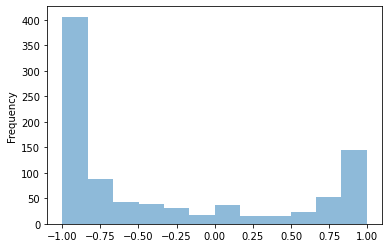

In [68]:
df_preprocessing[df_preprocessing['subreddit']=='depression']['full_text_score'].plot.hist(bins=12, alpha=0.5)

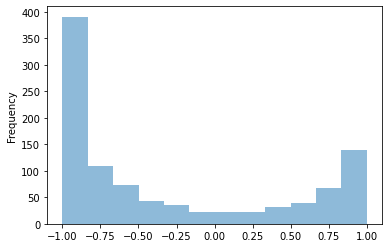

In [69]:
df_preprocessing[df_preprocessing['subreddit']=='Anxiety']['full_text_score'].plot.hist(bins=12, alpha=0.5)

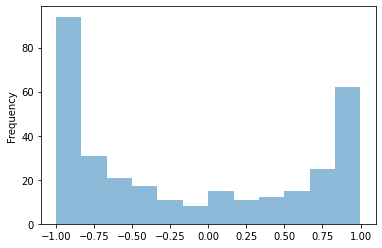

In [70]:
df_preprocessing[df_preprocessing['subreddit']=='bipolar']['full_text_score'].plot.hist(bins=12, alpha=0.5)

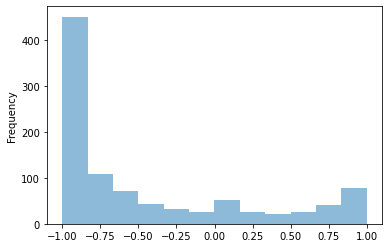

In [71]:
df_preprocessing[df_preprocessing['subreddit']=='SuicideWatch']['full_text_score'].plot.hist(bins=12, alpha=0.5)

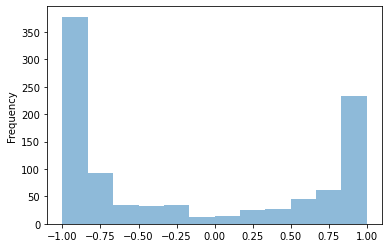

In [72]:
df_preprocessing[df_preprocessing['subreddit']=='BPD']['full_text_score'].plot.hist(bins=12, alpha=0.5)

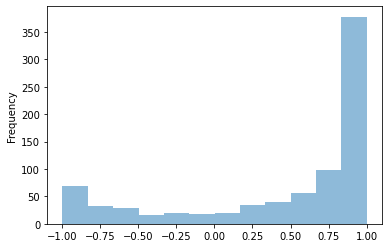

In [73]:
df_preprocessing[df_preprocessing['subreddit']=='CasualConversation']['full_text_score'].plot.hist(bins=12, alpha=0.5)

# 4. Prediction 

## 4.1 Classification 

In [74]:
from sklearn.model_selection import train_test_split

## Case 1: Binary classification: healthy vs. non healthy

In [75]:
def binary_label(text):
    if text == 'CasualConversation':
        return 0
    return 1

binary_labels = df_preprocessing.subreddit.apply(lambda x: binary_label(x))

In [76]:
X = df_preprocessing.lemmatization_nuon_adj
y = df_preprocessing.subreddit.apply(lambda x: binary_label(x))

X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(X, y, test_size=0.4, random_state=0)

X_dev_binary, X_test_binary, y_dev_binary, y_test_binary = train_test_split(X_test_binary, y_test_binary, test_size=0.5, random_state=0)

### Most-frequent-label Classifier

In [77]:
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier

In [78]:
def most_frequent_classifier(X_train, X_dev, y_train, y_dev, preds=False):
    
    most_frequent = DummyClassifier(strategy='most_frequent')
    most_frequent.fit(X_train, y_train)
    
    dumb_predictions = most_frequent.predict(X_dev)

    print(classification_report(y_dev, dumb_predictions))
    
    if preds:
        return dumb_predictions

In [79]:
most_frequent_classifier(X_train_binary, X_dev_binary, y_train_binary, y_dev_binary)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       157
           1       0.87      1.00      0.93      1042

    accuracy                           0.87      1199
   macro avg       0.43      0.50      0.46      1199
weighted avg       0.76      0.87      0.81      1199



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### The Hulk with TF-IDF at post-level

In [80]:
from sklearn.linear_model import LogisticRegression

In [81]:
def hulk_vectorization_post(X_train, X_dev, X_test):
    
    vectorizer = TfidfVectorizer(ngram_range=(2,6), 
                                 min_df=0.001, 
                                 max_df=0.7, 
                                 analyzer='char',
                                 sublinear_tf=True)

    X_train = vectorizer.fit_transform(X_train)
    X_dev = vectorizer.transform(X_dev)
    X_test = vectorizer.transform(X_test)
    
    return X_train, X_dev, X_test

In [82]:
def hulk(X_train, X_dev, y_train, y_dev, model=None, preds=False):
        
    
    if model is None:
        classifier = LogisticRegression(n_jobs=-1, multi_class='auto', solver='lbfgs')
    else:
        classifier = model
    
    classifier.fit(X_train, y_train)
    
    predictions = classifier.predict(X_dev)
    print(classification_report(y_dev, predictions))
    
    if preds:
        return predictions

In [83]:
X_train_binary_post, X_dev_binary_post, X_test_binary_post = hulk_vectorization_post(X_train_binary, X_dev_binary, X_test_binary)

In [84]:
hulk(X_train_binary_post, X_dev_binary_post, y_train_binary, y_dev_binary, model=None)

              precision    recall  f1-score   support

           0       1.00      0.04      0.07       157
           1       0.87      1.00      0.93      1042

    accuracy                           0.87      1199
   macro avg       0.94      0.52      0.50      1199
weighted avg       0.89      0.87      0.82      1199



### The Hulk with TF-IDF at document-level

In [85]:
def hulk_vectorization_docs(X_train, y_train, X_dev, X_test):
    
    join_train = pd.merge(X_train, y_train, left_index=True, right_index=True)
    
    document_list = []

    for subreddit in list(set(join_train['subreddit'])):
        document_list.append(' '.join(join_train[join_train['subreddit']==subreddit]['lemmatization_nuon_adj']))
        
    vectorizer = TfidfVectorizer(ngram_range=(2,6), 
                             min_df=0.001, 
                             max_df=0.7, 
                             analyzer='char',
                             sublinear_tf=True)

    vectorizer.fit(document_list) 
    
    X_train_doc = vectorizer.transform(X_train)
    X_dev_doc = vectorizer.transform(X_dev)
    X_test_doc = vectorizer.transform(X_test)
    
    return X_train_doc, X_dev_doc, X_test_doc

In [86]:
X_train_binary_docs, X_dev_binary_docs, X_test_binary_docs = hulk_vectorization_docs(X_train_binary, y_train_binary, X_dev_binary, X_test_binary)

In [87]:
hulk(X_train_binary_docs, X_dev_binary_docs, y_train_binary, y_dev_binary, model=None)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       157
           1       0.87      1.00      0.93      1042

    accuracy                           0.87      1199
   macro avg       0.43      0.50      0.46      1199
weighted avg       0.76      0.87      0.81      1199



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [88]:
df_reduced = df_preprocessing[df_preprocessing['subreddit'].isin(['depression', 'Anxiety', 'CasualConversation', 'SuicideWatch'])]

In [89]:
df_reduced.shape

(3695, 9)

In [90]:
def generalised_depression_label(x):
    if x == 'SuicideWatch':
        return 'depression'
    return x

In [91]:
X = df_reduced.lemmatization_nuon_adj
y = df_reduced.subreddit.apply(lambda x: generalised_depression_label(x))

# Split train and test
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X, y, test_size=0.4, random_state=0)

# Split test into dev and test
X_dev_reduced, X_test_reduced, y_dev_reduced, y_test_reduced = train_test_split(X_test_reduced, y_test_reduced, test_size=0.5, random_state=0)

### Most-frequent-label Classifier 

In [92]:
dumb_predictions = most_frequent_classifier(X_train_reduced, X_dev_reduced, y_train_reduced, y_dev_reduced, preds=True)

                    precision    recall  f1-score   support

           Anxiety       0.00      0.00      0.00       204
CasualConversation       0.00      0.00      0.00       175
        depression       0.49      1.00      0.66       360

          accuracy                           0.49       739
         macro avg       0.16      0.33      0.22       739
      weighted avg       0.24      0.49      0.32       739



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### The Hulk with TF-IDF at post-level

In [93]:
X_train_reduced_post, X_dev_reduced_post, X_test_reduced_post = hulk_vectorization_post(X_train_reduced, X_dev_reduced, X_test_reduced)

In [94]:
hulk_predictions = hulk(X_train_reduced_post, X_dev_reduced_post, y_train_reduced, y_dev_reduced, model=None, preds=True)

                    precision    recall  f1-score   support

           Anxiety       0.89      0.71      0.79       204
CasualConversation       0.80      0.52      0.63       175
        depression       0.73      0.95      0.83       360

          accuracy                           0.78       739
         macro avg       0.81      0.72      0.75       739
      weighted avg       0.79      0.78      0.77       739



### The Hulk with TF-IDF at document-level

In [95]:
X_train_reduced_docs, X_dev_reduced_docs, X_test_reduced_docs = hulk_vectorization_docs(X_train_reduced, y_train_reduced, X_dev_reduced, X_test_reduced)

In [96]:
hulk(X_train_reduced_docs, X_dev_reduced_docs, y_train_reduced, y_dev_reduced, model=None)

                    precision    recall  f1-score   support

           Anxiety       0.95      0.37      0.53       204
CasualConversation       0.50      0.01      0.01       175
        depression       0.55      1.00      0.71       360

          accuracy                           0.59       739
         macro avg       0.66      0.46      0.42       739
      weighted avg       0.65      0.59      0.49       739



### Improved models

#### a. The Hulk with hyperparameter tuning

In [97]:
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV

clf = LogisticRegression(n_jobs=-1)


param_grid = {'C': [20, 10, 5, 1, 0.01],
              'class_weight': ['balanced', None]}

search = GridSearchCV(clf, 
                      param_grid, 
                      cv=5, 
                      scoring='f1_micro') 

search.fit(X_train_reduced_post, y_train_reduced)

GridSearchCV(cv=5, estimator=LogisticRegression(n_jobs=-1),
             param_grid={'C': [20, 10, 5, 1, 0.01],
                         'class_weight': ['balanced', None]},
             scoring='f1_micro')

In [98]:
clf_best = search.best_estimator_
print(clf_best.get_params())

{'C': 1, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': -1, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [99]:
print(search.best_score_)

0.8164185630325583


In [100]:
clf_best.fit(X_train_reduced_post, y_train_reduced)
predictions_a = clf_best.predict(X_dev_reduced_post)
print(classification_report(y_dev_reduced, predictions_a))

                    precision    recall  f1-score   support

           Anxiety       0.87      0.74      0.80       204
CasualConversation       0.62      0.79      0.70       175
        depression       0.85      0.81      0.83       360

          accuracy                           0.79       739
         macro avg       0.78      0.78      0.78       739
      weighted avg       0.80      0.79      0.79       739



#### b. The Hulk with dimensionality reduction (with best classifier)


In [101]:
X_train_reduced_post.shape

(2217, 74003)

### Significance testing

In [102]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

def bootstrap_sample(system1, system2, gold, samples=1000, score=f1_score, average='micro'):

    N = len(gold) 
    
    assert len(system1) == N and len(system2) == N, 'samples have different lengths'

    base_score1 = score(gold, system1, average=average)
    base_score2 = score(gold, system2, average=average)
    print("Base difference: {} vs. {}".format(base_score1, base_score2))

    if base_score2 > base_score1:
        system1, system2 = system2, system1
        base_score1, base_score2 = base_score2, base_score1
    
    basedelta = base_score1 - base_score2
    assert basedelta > 0, 'Wrong system first, system1 needs to be better!'

    system1 = np.array(system1)
    system2 = np.array(system2)
    gold = np.array(gold)

    p = 0
    deltas = []
    for i in range(samples):
        sample = np.random.choice(N, size=N, replace=True)

        sample1 = system1[sample]
        sample2 = system2[sample]
        gold_sample = gold[sample]

        sample_score1 = score(gold_sample, sample1, average=average)
        sample_score2 = score(gold_sample, sample2, average=average)
        sample_delta = sample_score1 - sample_score2

        if sample_delta > 2*basedelta:
            p += 1
        deltas.append(sample_delta)
                
    return p/samples, deltas

# 4.2 Structured Prediction 

In [103]:
import random

def generate_topics(num_topics, df=df_preprocessing['lemmatization_nuon_adj']):
    
    instances = df.apply(str.split).tolist()
    
    # shuffle instances
    random.shuffle(instances)
    
    phrases = Phrases(instances, min_count=5, threshold=1)
    instances_colloc = phrases[instances]

    dictionary = Dictionary(instances_colloc)
    dictionary.filter_extremes(no_below=50, no_above=0.3)
    
    ldacorpus = [dictionary.doc2bow(text) for text in instances]
    tfidfmodel = TfidfModel(ldacorpus)
    model_corpus = tfidfmodel[ldacorpus]
    num_passes = 10
    chunk_size = len(model_corpus) * num_passes/200
    
    dev_size = len(df)

    model = LdaMulticore(num_topics=num_topics, 
                         corpus=model_corpus[:dev_size],  
                         id2word=dictionary, 
                         workers=min(10, multiprocessing.cpu_count()-1), 
                         passes=num_passes, 
                         chunksize=chunk_size,
                         alpha=0.5,
                         random_state=42)



    topic_corpus = model[model_corpus]

    topic_sep = re.compile("0\.[0-9]{3}\*")
    model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) 
                    for topic_no, model_topic in
                    model.print_topics(num_topics=num_topics, num_words=20)]

    descriptors = []
    for i, m in model_topics:
        print(i+1, ", ".join(m[:10]))
        descriptors.append(", ".join(m[:10]).replace('"', ''))
    
    return model_topics

In [104]:
data = df_preprocessing['lemmatization_nuon_adj'].copy()
data = data.sample(frac=1)

n_splits = 5
N = len(data)
size = int(N*(1/n_splits)) 

data_split_list = []

for i in range(n_splits):
    
    start_index = i*size
    end_index = (i+1)*size
    
    data_i = data[start_index:end_index]
    
    data_split_list.append(data_i)

In [105]:
len(data_split_list)

5

In [106]:
len(data_split_list[0])

1199

In [107]:
def clean_topics(topics):
    
    topic_1 = []

    for t in topics[0][1][:20]:
        topic_1.append(t[1:-1])
        
    topic_2 = []

    for t in topics[1][1][:20]:
        topic_2.append(t[1:-1])
        
    topic_mixed = list(set(topic_1) & set(topic_2))
    
    return topic_1, topic_2, topic_mixed

In [108]:
def check_good_topics(topic_1, topic_2, topic_mixed, topic_pilar = 'depression'):
    
    dict_topic = dict()

    if topic_pilar in topic_mixed:
        return dict_topic

    if topic_pilar not in topic_1+topic_2:
        return dict_topic

    if topic_pilar in topic_1:
        dict_topic['topic_1'] = 'A'
        dict_topic['topic_2'] = 'B'

    else:
        dict_topic['topic_1'] = 'B'
        dict_topic['topic_2'] = 'A'
        
    return dict_topic

In [109]:
def build_n_topic_models(n_splits=n_splits, num_topics=2):
    for i in range(n_splits):

        good_current_topic = False

        while not good_current_topic:

            print(f"Start iteration for topic number {i+1}")

            topics = generate_topics(num_topics)
            

            topic_1, topic_2, topic_mixed = clean_topics(topics)
            dict_topic = check_good_topics(topic_1, topic_2, topic_mixed, topic_pilar = 'anxiety')

            if not dict_topic:
                print(f"\tCURRENT ITERATION FAILED: start again")

            else:
                good_current_topic = True
                print(f"\tDone")
                yield (topic_1, topic_2, topic_mixed, dict_topic)

### Structured Perceptron

In [110]:
from collections import defaultdict, Counter
import json
import re
import numpy as np
import sys
import pickle
import random

np.set_printoptions(precision=2)

users = re.compile('@[^ ]+')
numbers = re.compile('[0-9]')
urls = re.compile("(https?:\/\/)?(?:www\.|(?!www))?[^\s\.]+\.[^\s]{2,}|(www)?\.[^\s]+\.[^\s]{2,}")

In [111]:
class StructuredPerceptron(object):


    def __init__(self):
       
        self.tags = set()
        self.feature_weights = defaultdict(lambda: defaultdict(float)) 
        self.weight_totals = defaultdict(lambda: defaultdict(float)) 
        self.timestamps = defaultdict(lambda: defaultdict(float)) 

        self.tag_dict = defaultdict(set) 

        self.START = "__START__"
        self.END = "__END__"
        
        
    def normalize(self, word):
        
        return re.sub(urls, 'URL', re.sub(users, '@USER', re.sub(numbers, '0', word.strip().lower())))

    
    def evaluate(self, data_instances, method='greedy'):
        correct = 0
        total = 0
        for (words, tags) in data_instances:
            try:
                preds = self.predict(words, method=method)
            except IndexError:
                continue
                
            matches = sum(map(lambda x: int(x[0]==x[1]), zip(preds, tags)))
            correct += matches
            total += len(tags)
        return correct/total
        
    
    def fit(self, instances, dev_instances=None, iterations=10, learning_rate=0.25, inference='greedy', verbose=False):     
        
        for (words, tags) in instances:
            self.tags.update(set(tags))

            for word, tag in zip(words, tags):
                self.tag_dict[self.normalize(word)].add(tag)
        
            
        for iteration in range(1, iterations+1):
            correct = 0
            total = 0
            if verbose:
                print('Iteration {}'.format(iteration+1), file=sys.stderr, flush=True)
                print("*" * 15, file=sys.stderr, flush=True)

            random.shuffle(instances)
            for i, (words, tags) in enumerate(instances):
                if i > 0:
                    if i%1000==0:
                        print('%s'%i, file=sys.stderr, flush=True)
                    elif i%20==0:
                        print('.', file=sys.stderr, flush=True, end='')

                try:
                    prediction = self.predict(words, method=inference)
                except IndexError:
                    continue

                global_gold_features, global_prediction_features = self.get_global_features(words, prediction, tags)
                                    
                for tag, fids in global_gold_features.items():
                    for fid, count in fids.items():
                        nr_iters_at_this_weight = iteration - self.timestamps[fid][tag]
                        self.weight_totals[fid][tag] += nr_iters_at_this_weight * self.feature_weights[fid][tag]
                        self.timestamps[fid][tag] = iteration
                        self.feature_weights[fid][tag] += learning_rate * count

                for tag, fids in global_prediction_features.items():
                    for fid, count in fids.items():
                        nr_iters_at_this_weight = iteration - self.timestamps[fid][tag]
                        self.weight_totals[fid][tag] += nr_iters_at_this_weight * self.feature_weights[fid][tag]
                        self.timestamps[fid][tag] = iteration
                        self.feature_weights[fid][tag] -= learning_rate * count
                        
                # compute training accuracy for this iteration
                correct += sum([int(predicted_tag == true_tag) for predicted_tag, true_tag in zip(prediction, tags)])
                total += len(tags)

                # output examples
                if verbose and i%1000==0:
                    print("current word accuracy:{:.2f}".format(correct/total))
                    print(list(zip(words, 
                                   [self.normalize(word) for word in words], 
                                   tags, 
                                   prediction)), file=sys.stderr, flush=True)
            
            print('\t{} features'.format(len(self.feature_weights)), file=sys.stderr, flush=True)
            print('\tTraining accuracy: {:.2f}\n'.format(correct/total), file=sys.stderr, flush=True)
            if dev_instances:
                print('\tDevelopment accuracy: {:.2f}\n'.format(self.evaluate(dev_instances, method=inference)), file=sys.stderr, flush=True)
         
        # average weights
        for feature, tags in self.feature_weights.items():
            for tag in tags:
                total = self.weight_totals[feature][tag]
                total += (iterations - self.timestamps[feature][tag]) * self.feature_weights[feature][tag]
                averaged = round(total / float(iterations), 3)
                self.feature_weights[feature][tag] = averaged


    def get_features(self, word, previous_tag2, previous_tag, words, i):
        
        prefix = word[:3]
        suffix = word[-3:]

        features = {
                    'PREFIX={}'.format(prefix),
                    'SUFFIX={}'.format(suffix),
                    'LEN<=3={}'.format(len(word)<=3),
                    'FIRST_LETTER={}'.format(word[0]),
                    'WORD={}'.format(word),
                    'NORM_WORD={}'.format(words[i]),
                    'PREV_WORD={}'.format(words[i-1]),
                    'PREV_WORD_PREFIX={}'.format(words[i-1][:3]),
                    'PREV_WORD_SUFFIX={}'.format(words[i-1][-3:]),
                    'PREV_WORD+WORD={}+{}'.format(words[i-1], words[i]),
                    'NEXT_WORD={}'.format(words[i+1]),
                    'NEXT_WORD_PREFIX={}'.format(words[i+1][:3]),
                    'NEXT_WORD_SUFFIX={}'.format(words[i+1][-3:]),
                    'WORD+NEXT_WORD={}'.format(word, words[i+1]),
                    'NEXT_2WORDS={}+{}'.format(words[i+1], words[i+2]),
                    'PREV_TAG={}'.format(previous_tag),                 # previous tag
                    'PREV_TAG2={}'.format(previous_tag2),                 # two-previous tag
                    'PREV_TAG_BIGRAM={}+{}'.format(previous_tag2, previous_tag),  # tag bigram
                    'PREV_TAG+WORD={}+{}'.format(previous_tag, word),            # word-tag combination
                    'PREV_TAG+PREFIX={}_{}'.format(previous_tag, prefix),        # prefix and tag
                    'PREV_TAG+SUFFIX={}_{}'.format(previous_tag, suffix),        # suffix and tag
                    'WORD+TAG_BIGRAM={}+{}+{}'.format(word, previous_tag2, previous_tag),
                    'SUFFIX+2TAGS={}+{}+{}'.format(suffix, previous_tag2, previous_tag),
                    'PREFIX+2TAGS={}+{}+{}'.format(prefix, previous_tag2, previous_tag),
                    'BIAS'
            }
        return features
    
    
    def get_global_features(self, words, predicted_tags, true_tags):
       
        context = [self.START] + [self.normalize(word) for word in words] + [self.END, self.END]

        global_gold_features = defaultdict(lambda: Counter())
        global_prediction_features = defaultdict(lambda: Counter())

        prev_predicted_tag = self.START
        prev_predicted_tag2 = self.START
        
        for j, (word, predicted_tag, true_tag) in enumerate(zip(words, predicted_tags, true_tags)):
            prediction_features = self.get_features(word, prev_predicted_tag2, prev_predicted_tag, context, j+1)

            global_prediction_features[predicted_tag].update(prediction_features)
            global_gold_features[true_tag].update(prediction_features)

            prev_predicted_tag2 = prev_predicted_tag
            prev_predicted_tag = predicted_tag

        return global_gold_features, global_prediction_features
            
    
    def get_scores(self, features):
        scores = defaultdict(float)
        
        for feature in features:
            if feature not in self.feature_weights:
                continue
            weights = self.feature_weights[feature]
            for tag, weight in weights.items():
                scores[tag] += weight

        if not scores:
            scores[list(self.tags)[0]] = 1
        
        return scores


    def predict(self, words, method='greedy'):
        if method == 'greedy':
            return self.predict_greedy(words)
        elif method == 'viterbi':
            return self.predict_viterbi(words)


    def predict_viterbi(self, words):
        context = [self.START] + [self.normalize(word) for word in words] + [self.END, self.END]

        N = len(words)
        M = len(self.tags) #number of tags
        tags = sorted(self.tags)

        # create trellis of size M (number of tags) x N (sentence length)
        Q = np.ones((M, N)) * float('-Inf')
        backpointers = np.ones((M, N), dtype=np.int16) * -1 #backpointers

        # initialize probs for tags j at position 1 (first word)
        features = self.get_features(words[0], self.START, self.START, context, 1)
        scores = self.get_scores(features)
        allowed_initial_tags = self.tag_dict[context[1]]

        for j in range(M):
            if not allowed_initial_tags or tags[j] in allowed_initial_tags:
                Q[j,0] = scores[tags[j]]

        # filling the lattice, for every position and every tag find viterbi score Q
        for i in range(1, N):
            allowed_tags = self.tag_dict[context[i+1]]

            # for every previous tag
            for j in range(M):
                best_score = 0.0#float('-Inf')
                prev_tag = tags[j]

                # skip impossible tags
                allowed_previous_tags = self.tag_dict[context[i]]
                if allowed_previous_tags and prev_tag not in allowed_previous_tags:
                    continue

                best_before = Q[j,i-1] # score of previous tag

                # for every possible pre-previous tag
                for k in range(M):
                    if i == 1:
                        prev2_tag = self.START
                    else:
                        prev2_tag = tags[k]
                        # skip impossible tags
                        allowed_previous2_tags = self.tag_dict[context[i-1]]
                        if allowed_previous2_tags and prev2_tag not in allowed_previous2_tags:
                            continue

                    # get features of word i with the two previous tags
                    features = self.get_features(words[i], prev2_tag, prev_tag, context, i+1)
                    scores = self.get_scores(features)

                    # update best score
                    for t in range(M):
                        tag = tags[t]
                        # if word is unknown, use all tags, otherwise allowed ones
                        if not allowed_tags or tag in allowed_tags:
                            tag_score = best_before + scores[tag]

                            if tag_score > best_score:
                                Q[t,i] = tag_score
                                best_score = tag_score
                                backpointers[t,i] = j

        # final best
        best_id = Q[:,-1].argmax()

        # print best tags in reverse order
        predtags = [tags[best_id]]

        for i in range(N-1,0,-1):
            idx = backpointers[best_id, i]
            predtags.append(tags[idx])
            best_id = idx

        #return reversed predtags
        return predtags[::-1]         

    
    def predict_greedy(self, words):
        context = [self.START] + [self.normalize(word) for word in words] + [self.END, self.END]
                
        prev_predicted_tag = self.START
        prev_predicted_tag2 = self.START

        out = []

        for j, word in enumerate(words):
            # for unambiguous words, just look up the tag
            predicted_tag = list(self.tag_dict[context[j+1]])[0] if len(self.tag_dict[context[j+1]]) == 1 else None

            if not predicted_tag:
                # get the predicted features. NB: use j+1, since context is longer than words
                prediction_features = self.get_features(word, prev_predicted_tag2, prev_predicted_tag, context, j+1)
                scores = self.get_scores(prediction_features)
                
                # predict the current tag
                predicted_tag = max(scores, key=scores.get)

            prev_predicted_tag2 = prev_predicted_tag
            prev_predicted_tag = predicted_tag

            out.append(predicted_tag)

        return out
        

    def save(self, file_name):
        print("saving model...", end=' ', file=sys.stderr)
        with open(file_name, "wb") as model:
            # pickle cannot save default_dictionaries
            # => make copy and turn into regular dictionaries
            save_feature_weights = defaultdict(lambda: defaultdict(float))
            save_feature_weights.update(self.feature_weights)
            save_tag_dict = defaultdict(set)
            save_tag_dict.update(self.tag_dict)

            save_feature_weights.default_factory = None
            save_tag_dict.default_factory = None
            pickle.dump((save_feature_weights, save_tag_dict, self.tags),
                     model, -1)
        print("done", file=sys.stderr)


    def load(self, file_name):
        print("loading model...", end=' ', file=sys.stderr)
        with open(file_name, 'rb') as model:
            try:
                parameters = pickle.load(model)
            except IOError:
                msg = ("No such model file.")
                raise MissingCorpusError(msg)

            feature_weights, tag_dict, tags = parameters
            self.tags = tags

            self.feature_weights = defaultdict(lambda: defaultdict(float))
            self.tag_dict = defaultdict(set)
            
            self.feature_weights.update(feature_weights)
            self.tag_dict.update(tag_dict)
        print("done", file=sys.stderr)
        return None